## **Introduction - CNN for Image Classification with ResNet50 and VGG 16**

**Moses Hashini Sharon -TP053387**

This classification model will be using two different Phases to show the importance of mask files in medical imaging.

1) Phase I- we will only use the actual image files and ignore the mask files to classify.

2) Phase II- we will overlay the actual image and the masks and use the overlayed images to classify and try to improve our model perfromance.

Then the models will be evaluated using conf matrix and classifcation reports to score the performance of both the models on both Phases.

We will analyse the importance of the mask(ground truth) files and overlaying the images to improve model accuracy.

## **Importing libraries**

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, ColorJitter
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image
from PIL import Image
import os
import shutil
import random

In [3]:
# Mount the drive to feed images
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##  **Dataset Overview**

Randomly select few images from each label to display the actual ultrasound image and its mask. We can see a pattern between benign and malignant labels. Normal class masks will not add much value here since its all black and uniform.We will still use the normal category in both of our models to treat the problem as a multiclassifcation problem. Our first approach will utilize only the ultrasound images where our second approach will overlay both images and use the overlayed image to classify.

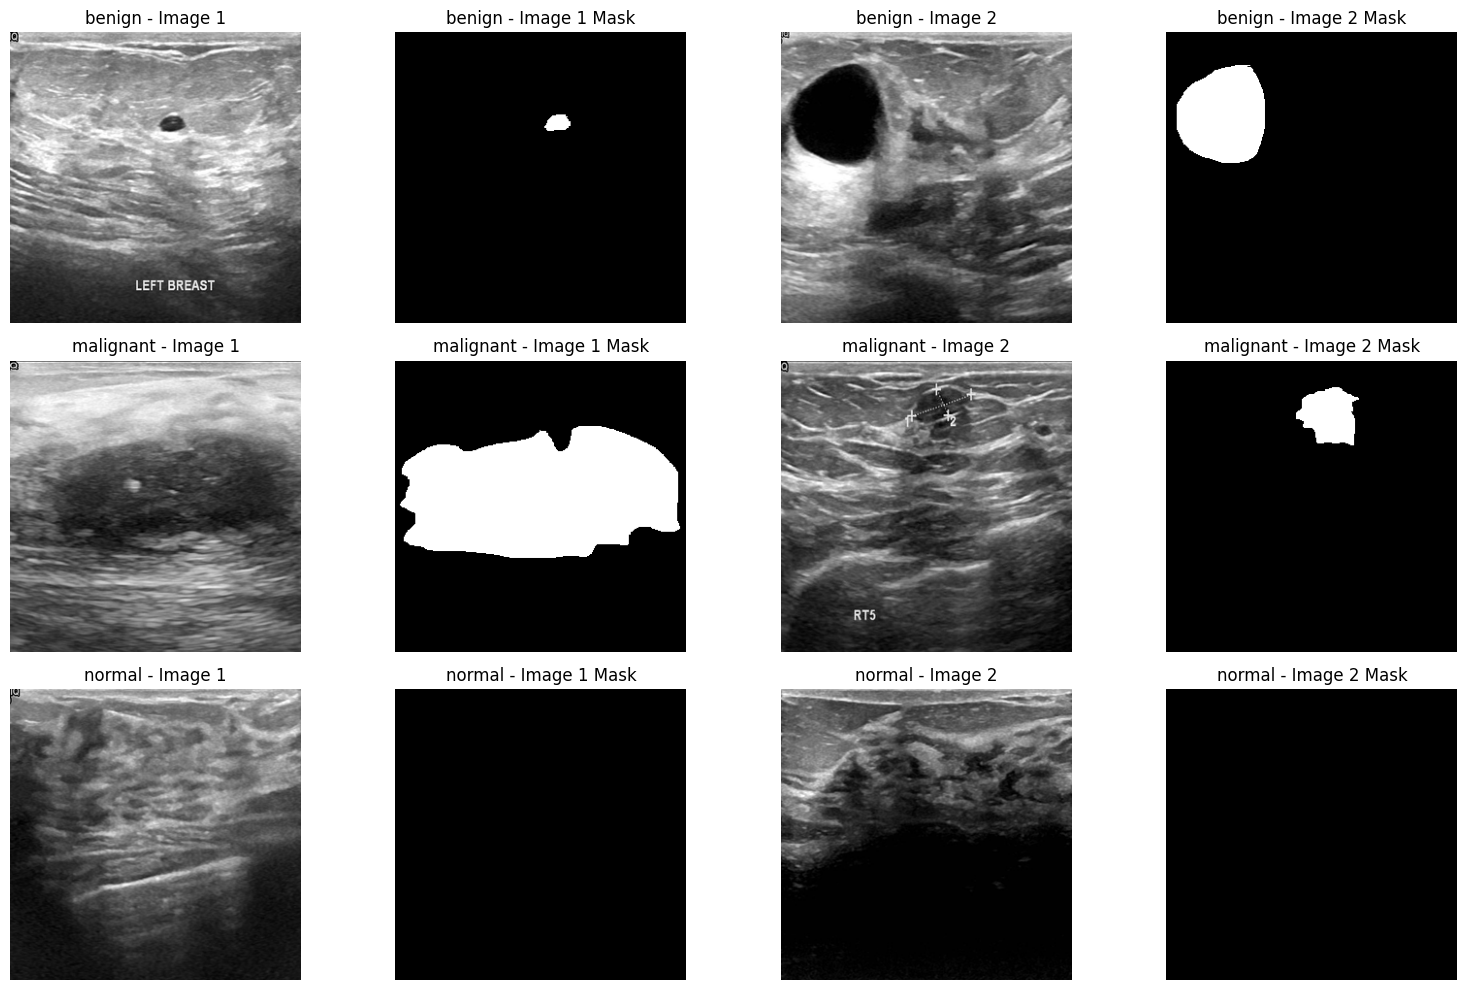

In [5]:
# Define the labels and corresponding directories
labels = ['benign', 'malignant', 'normal']
data_dir = '/content/drive/MyDrive/DL Assignment/Dataset_BUSI_with_GT'
working_dir = '/content/drive/MyDrive/DL Assignment'

# Create a figure to display the images
fig, axs = plt.subplots(3, 4, figsize=(16, 10))

# Desired width and height for each image
desired_width = 300  # Adjust as needed
desired_height = 300  # Adjust as needed

for i, label in enumerate(labels):
    label_dir = os.path.join(data_dir, label)

    # Get a list of image files
    image_files = [file for file in os.listdir(label_dir) if file.endswith('.png')]

    # Sort the list of image files
    image_files = sorted(image_files)

    # Loop through the first 4 image files
    for j in range(4):
        if j < len(image_files):
            # Load and resize the image
            image_path = os.path.join(label_dir, image_files[j])
            image = Image.open(image_path)
            image = image.resize((desired_width, desired_height), Image.LANCZOS)

            # Determine the label based on whether it's an image or a mask
            if j % 2 == 0:
                image_label = f'{label} - Image {j // 2 + 1}'
            else:
                image_label = f'{label} - Image {j // 2 + 1} Mask'

            # Display the image with the corresponding label
            axs[i, j].imshow(image)
            axs[i, j].set_title(image_label)
            axs[i, j].axis('off')

plt.tight_layout()
plt.show()


# **Phase 1 - Data Split and create folders- Excludes mask files**

The primary goal of both transformation and augmentation is to make the model more resilient to variations and noise in the input data, ultimately improving its ability to make accurate predictions on real-world, unseen data. These techniques are particularly important in deep learning, where models have a large number of parameters and can easily be overfit to the training data if not exposed to diverse examples. Augmentation helps the model generalize better to unseen data and reduces overfitting.

We will also be applying extra augmentation to our minority classes in the train dataset to balance out training dataset so our model can generalize better.




### **Create train/test validation folders and data split**

In [6]:
# Create a list to store file paths and labels
file_paths = []
labels = []

# Loop through the subdirectories (benign, malignant, normal)
for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        for image_file in os.listdir(label_dir):
            if image_file.endswith('.png') and not (image_file.endswith('_mask.png') or
                                                     image_file.endswith('_mask_1.png') or
                                                     image_file.endswith('_mask_2.png')):
                image_path = os.path.join(label_dir, image_file)
                labels.append(label)
                file_paths.append(image_path)

# Create a DataFrame to store the file paths and labels
data = pd.DataFrame({'Image_Path': file_paths, 'Label': labels})

# Split the dataset into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.15, random_state=42, stratify=data['Label'])
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42, stratify=train_data['Label'])

# Define the paths for the train, validation, and test directories
train_dir = '/content/drive/MyDrive/DL Assignment/train'
val_dir = '/content/drive/MyDrive/DL Assignment/validation'
test_dir = '/content/drive/MyDrive/DL Assignment/test'

# Create the train, validation, and test directories and subdirectories
for label in labels:
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

# Copy the images to the corresponding directories
for _, row in train_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(train_dir, label))

for _, row in val_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(val_dir, label))

for _, row in test_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(test_dir, label))



### **Get the label counts after split - excludes mask files**

In [7]:
import os

# List the subdirectories (benign, malignant, normal)
subdirectories = ['benign', 'malignant', 'normal']

# Dictionary to store file counts
file_counts = {}

# Loop through the subdirectories and count files in each
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(train_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

# Print the file counts
for category, count in file_counts.items():
   # print("Train folder counts including masks:")
    print(f"Train {category}: {count}")

# List the subdirectories (benign, malignant, normal)
subdirectories = ['benign', 'malignant', 'normal']

# Dictionary to store file counts
file_counts = {}

# Loop through the subdirectories and count files in each
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(val_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

# Print the file counts
for category, count in file_counts.items():
    #print("Validation folder counts including masks:")
    print(f"Validation {category}: {count}")

# List the subdirectories (benign, malignant, normal)
subdirectories = ['benign', 'malignant', 'normal']

# Dictionary to store file counts
file_counts = {}

# Loop through the subdirectories and count files in each
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(test_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

# Print the file counts
for category, count in file_counts.items():
    #print("test folder counts including masks:")
    print(f"test {category}: {count}")


Train benign: 334
Train malignant: 151
Train normal: 96
Validation benign: 59
Validation malignant: 27
Validation normal: 17
test benign: 69
test malignant: 32
test normal: 20


### **Display Ultrasound images used in 1st Phase**

<ipython-input-7-ff187e2e51b5>:22: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((desired_width, desired_height), Image.ANTIALIAS)


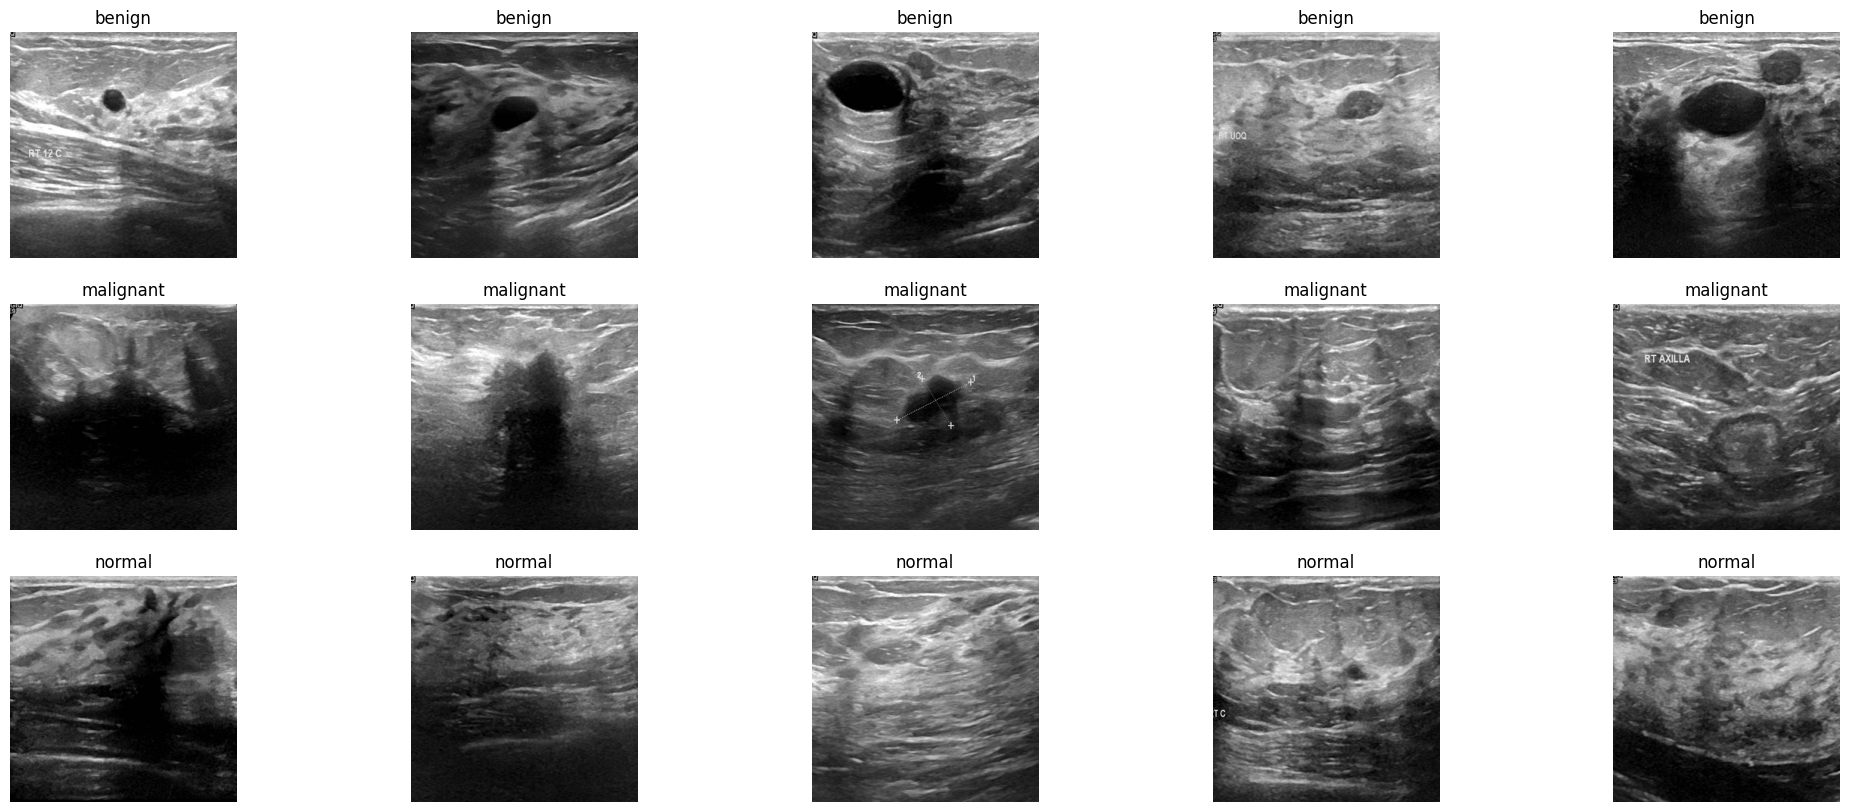

In [ ]:
# Create subdirectories for each label
labels = ['benign', 'malignant', 'normal']
label_dirs = [os.path.join(train_dir, label) for label in labels]

# Create a figure to display the images
fig, axs = plt.subplots(3, 5, figsize=(25, 10))

# Desired width and height for each image
desired_width = 300  # Adjust as needed
desired_height = 300  # Adjust as needed

# Loop through each label and display 5 images
for i, label_dir in enumerate(label_dirs):
    # Get a list of image files (excluding mask files)
    images = [image for image in os.listdir(label_dir) if not image.endswith('_mask.png')][:5]

    for j, image_filename in enumerate(images):
        image_path = os.path.join(label_dir, image_filename)
        image = Image.open(image_path)

        # Resize the image to the desired width and height
        image = image.resize((desired_width, desired_height), Image.ANTIALIAS)

        # Display the image in the subplot
        axs[i, j].imshow(image)
        axs[i, j].set_title(labels[i])
        axs[i, j].axis('off')

plt.show()

### **Model 1-ResNet50 CNN**

#### **Define Data Transformers/ Augmentations and Creating DataLoaders**

Apply transfromation and augmentation to the datasets. Augmentation is only applied to the training data with extra focus on minority classes to balance the dataset. Calling the function that was defined earlier in the notebook.

In [8]:
# Define the minority classes in your dataset
class_names = ['malignant', 'normal','benign']
minority_classes = ['malignant', 'normal']

# Define custom data transformations for minority classes
minority_class_transforms = transforms.Compose([
    RandomHorizontalFlip(p=0.9),  # Apply with 90% probability
    RandomRotation(15, expand=False, center=None),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

# Define data transformations for train, validation, and test sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomApply([minority_class_transforms], p=0.5) if any(cls in minority_classes for cls in class_names) else transforms.RandomApply([], p=0.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create datasets for train, test and val
image_datasets = {
    x: ImageFolder(
        root=os.path.join(working_dir, x),
        transform=data_transforms[x]
    )
    for x in ['train', 'validation', 'test']
}

# Specify batch size for dataloaders
batch_size = 32

# Create dataloaders for train, validation, and test
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
               for x in ['train', 'validation', 'test']}

# Calculate dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}

# Get class labels
class_names = image_datasets['train'].classes

# Print dataset sizes and class labels
print("Dataset Sizes:", dataset_sizes)
print("Class Labels:", class_names)

Dataset Sizes: {'train': 581, 'validation': 103, 'test': 121}
Class Labels: ['benign', 'malignant', 'normal']


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#### **Training the model with early stopping**

Adding early stop to avoid extra processing time. Tranining will stop if validation loss doesn't improve for 2 consecutive epochs.

In [ ]:
# Define the training function with early stopping and additional features
def train_model_with_early_stopping(model, lossFunction, optimizer, scheduler, dataloaders, dataset_sizes, class_names, device, num_epochs=20, patience=2):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')  # Initialize best_loss with a large value
    consecutive_epochs_without_improvement = 0

    # Lists to store training and validation losses
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = lossFunction(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Append training loss here
                if phase == 'train':
                    train_losses.append(loss.item())  # Append training loss
                else:
                    val_losses.append(loss.item())  # Append validation loss

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Early stopping: Check if validation loss improved
            if phase == 'validation':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    consecutive_epochs_without_improvement = 0
                else:
                    consecutive_epochs_without_improvement += 1
                val_losses.append(epoch_loss)

        # Check if early stopping criteria are met
        if consecutive_epochs_without_improvement >= patience:
            print(f"Early stopping after {epoch} epochs")
            break
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:.4f}'.format(best_loss))

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Calculate classification report and confusion matrix for validation data
    y_true = []
    y_pred = []

    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        for inputs, labels in dataloaders['validation']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Generate classification report
    target_names = [str(class_names[i]) for i in range(len(class_names))]
    print(classification_report(y_true, y_pred, target_names=target_names))

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    return model

Point to GPU if exists

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### **Model Fitting**

transfer learning- We wil use a pre trained resnet model and train out model.where the model can transfer its existing knowledge on a more customized dataset

In [ ]:
#Transfer Learning by fineTuning the pretrained Resnet101 Model
#Load Resnet101 pretained Model
#Resnet101 = models.resnet101(pretrained=True)
#If pretained is not working, you can also use weights instead.
Resnet101 = models.resnet101(weights=True)

print(Resnet101)
#Set the resnet param.requires_grad = True to calculate the gradient,
#so that model fine-tunes the weights of the pretrained network
#by continuing the backpropagation.
for param in Resnet101.parameters():
    param.requires_grad = True

#Get the number of Input features of Resnet last fully connected layer
#because we are going to replace it with new fully connected layer.
in_features = Resnet101.fc.in_features

#Reset the final fully connected layer of the of the pre-trained Resnet.
Resnet101.fc = nn.Linear(in_features, len(class_names))

Resnet_fineTuning = Resnet101.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Defining optimizer, hyperparameters and loss function

In [ ]:
#Define optimzation algorithm
optimizer = optim.Adam(Resnet_fineTuning.parameters(), lr=0.00005)

# Decay LR by a factor of 0.1 every 7 epochs
Decay_Learning_Rate = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

#Define loss functions
Loss_Function = nn.CrossEntropyLoss()

#### **Fine Tuning with learning Rate**

In [ ]:
model_fineTuning = train_model_with_early_stopping(
    Resnet_fineTuning, Loss_Function, optimizer, Decay_Learning_Rate,
    dataloaders, dataset_sizes, class_names, device,num_epochs=20, patience=2)
torch.save(model_fineTuning, "/content/drive/MyDrive/DL Assignment/Resnet_fineTuning.pth")

Epoch 0/19
----------
train Loss: 0.3339 Acc: 0.8845
validation Loss: 0.4317 Acc: 0.7900

Epoch 1/19
----------
train Loss: 0.1941 Acc: 0.9538
validation Loss: 0.3802 Acc: 0.8600

Epoch 2/19
----------
train Loss: 0.1832 Acc: 0.9343
validation Loss: 0.3452 Acc: 0.8600

Epoch 3/19
----------
train Loss: 0.1737 Acc: 0.9485
validation Loss: 0.3431 Acc: 0.8600

Epoch 4/19
----------
train Loss: 0.1644 Acc: 0.9485
validation Loss: 0.3769 Acc: 0.8600

Epoch 5/19
----------
train Loss: 0.1514 Acc: 0.9609
validation Loss: 0.3141 Acc: 0.8900

Epoch 6/19
----------
train Loss: 0.1308 Acc: 0.9627
validation Loss: 0.3229 Acc: 0.8900

Epoch 7/19
----------
train Loss: 0.1374 Acc: 0.9609
validation Loss: 0.3299 Acc: 0.8800
Early stopping after 7 epochs
Training complete in 1m 35s
Best val Loss: 0.3141
              precision    recall  f1-score   support

      benign       0.91      0.91      0.91        56
   malignant       0.81      0.81      0.81        27
      normal       0.94      0.94     

#### **Model Evaluation Using ultrasound image files only**

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


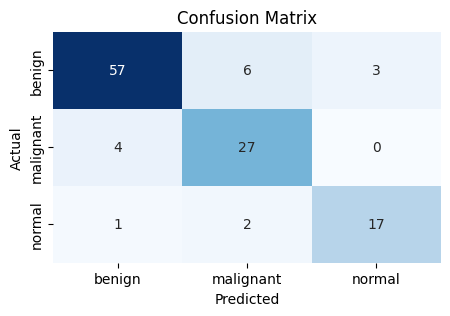

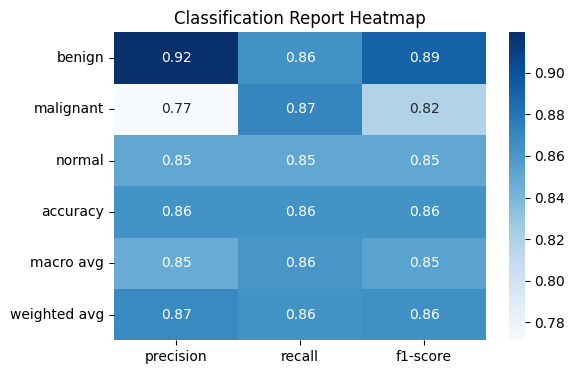

Simplified Classification Report:
             benign  malignant  normal  accuracy  macro avg  weighted avg
precision  0.919355   0.771429    0.85  0.863248   0.846928      0.868305
recall     0.863636   0.870968    0.85  0.863248   0.861535      0.863248
f1-score   0.890625   0.818182    0.85  0.863248   0.852936      0.864486


In [ ]:
# Define label names
label_names = [str(class_names[i]) for i in range(len(class_names))]

# Calculate classification report and confusion matrix on unseen test data
y_true = []
y_pred = []

model_fineTuning.eval()  # Set model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_fineTuning(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Generate classification report
classification_rep = classification_report(y_true, y_pred, target_names=label_names, output_dict=True)

# Generate confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix with label names
plt.figure(figsize=(5, 3))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Convert the classification report to a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(pd.DataFrame(classification_rep).iloc[:-1, :].T, annot=True, cmap='Blues', fmt='.2f')  # Simplify classification report
plt.title('Classification Report Heatmap')
plt.show()

# Print the simplified classification report
print("Simplified Classification Report:")
print(pd.DataFrame(classification_rep).iloc[:-1, :])  # Display without support and avg/total rows


#### **Visualizing Predictions- Actual vs Prediction**

<ipython-input-18-c5431dfb545f>:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'mask' not in test_data[1][i]:


1/1 [==============================] - 19s 19s/step


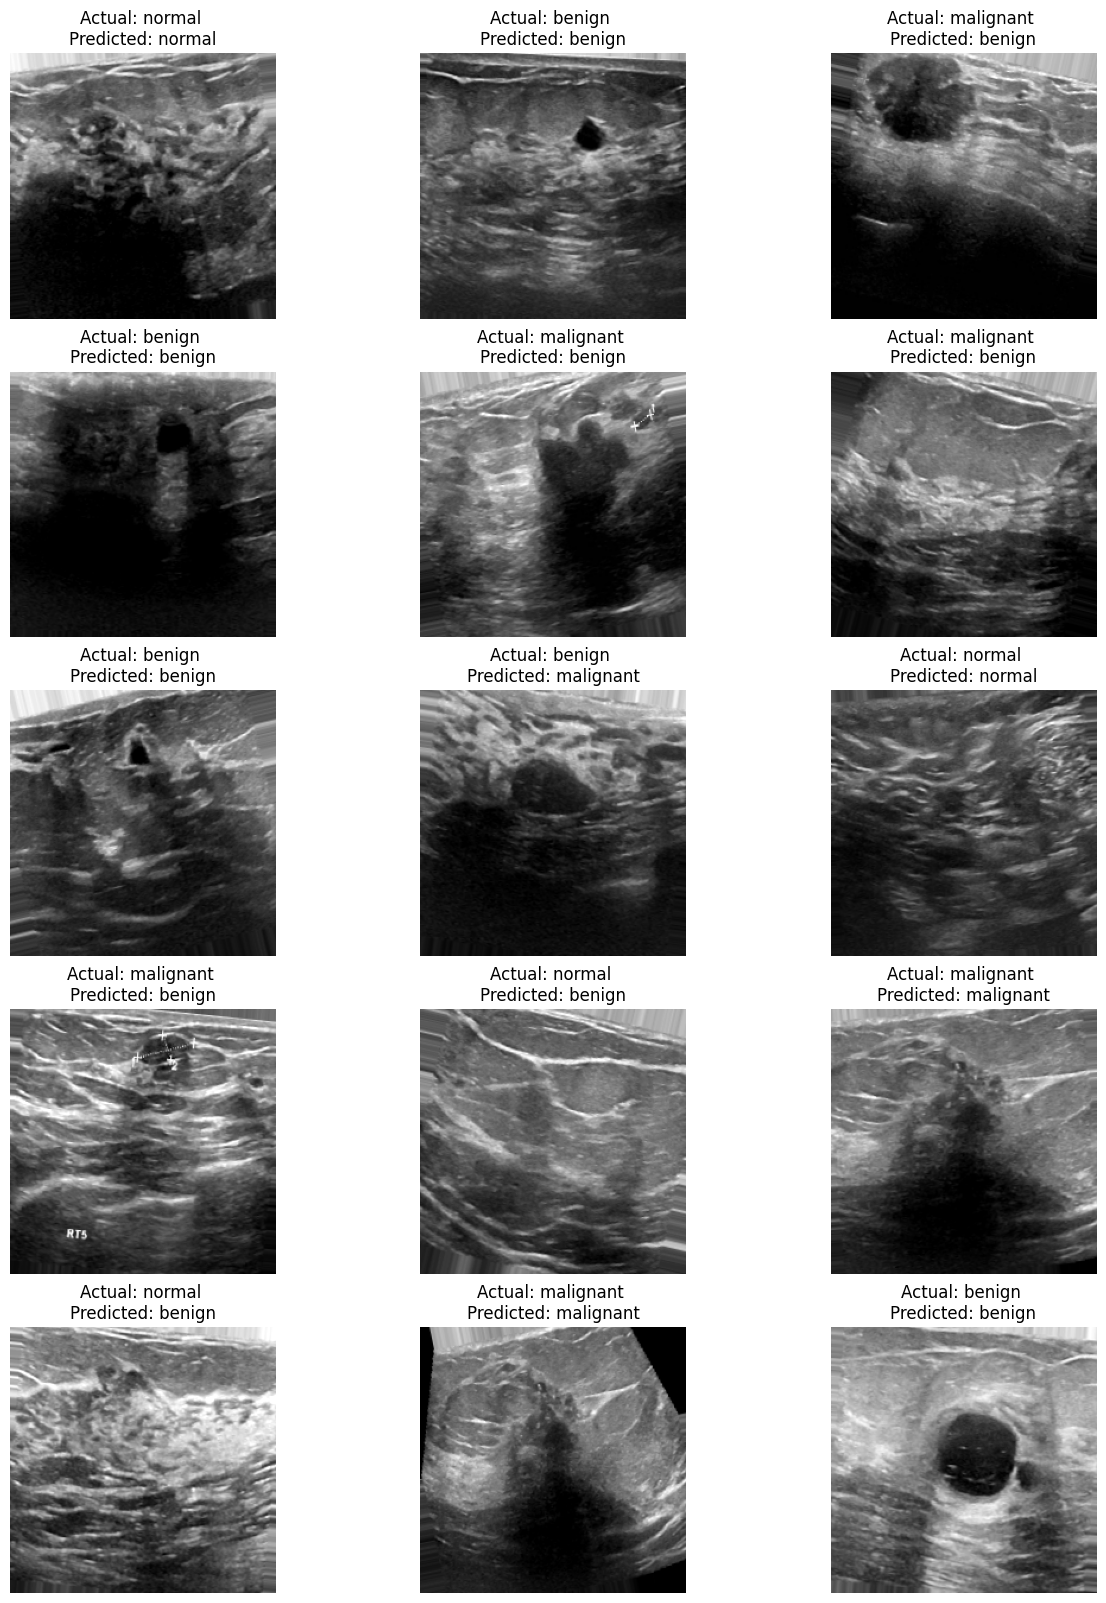

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Set the number of images to display
num_images_to_display = 15

# Create a DataLoader for the test dataset (assuming you have a 'test_generator' for VGG16)
test_data = next(test_generator)

# Get a batch of test data excluding mask images
inputs, labels = [], []
for i in range(len(test_data[1])):
    if 'mask' not in test_data[1][i]:
        inputs.append(test_data[0][i])
        labels.append(test_data[1][i])

inputs = np.array(inputs)
labels = np.array(labels)

# Convert images to grayscale
grayscale_images = np.mean(inputs, axis=-1)  # Convert RGB to grayscale

# Get model predictions
predictions = model.predict(inputs)
preds = np.argmax(predictions, axis=1)

# Plot the grayscale images with labels and predictions
plt.figure(figsize=(15, 20))  # Increase the height to accommodate 5 rows
for i in range(num_images_to_display):
    ax = plt.subplot(5, 3, i + 1)  # Adjust the layout to 5 rows by 3 columns
    ax.axis('off')
    ax.set_title(f'Actual: {class_names[np.argmax(labels[i])]} \nPredicted: {class_names[preds[i]]}')
    plt.imshow(grayscale_images[i], cmap='gray')  # Display the grayscale image

plt.show()

### **Model 2-VGG 16 CNN**

#### **Data Augmentation with Image Generator**

In [74]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the minority classes in your dataset
class_names = ['malignant', 'normal', 'benign']
minority_classes = ['malignant', 'normal']

# Create an instance of ImageDataGenerator for data augmentation
data_generator = ImageDataGenerator(
    rescale=1./255
)

# Define custom data generators for train, validation, and test sets
train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=class_names,
)

validation_generator = data_generator.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=class_names,
)

test_generator = data_generator.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=class_names,
)

Found 581 images belonging to 3 classes.
Found 103 images belonging to 3 classes.
Found 121 images belonging to 3 classes.


#### **Model Building**

In [31]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D

# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten(name='flattened'))
model.add(Dropout(0.5, name='dropout1'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3, name='dropout2'))
model.add(Dense(3, activation='softmax'))


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flattened (Flatten)         (None, 25088)             0         
                                                                 
 dropout1 (Dropout)          (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               6422784   
                                                                 
 dropout2 (Dropout)          (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 3)                 771       
                                                                 
Total params: 21138243 (80.64 MB)
Trainable params: 64

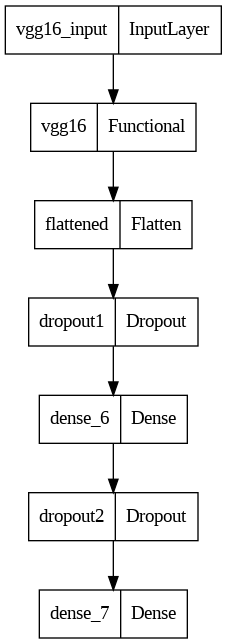

In [32]:
from keras.utils import  plot_model
from keras import optimizers
plot_model(model)

#### **Model Training with Early Stopping and DataGenerators**

In [73]:
# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Define the ModelCheckpoint callback to save the best model weights
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/DL Assignment/best_vgg16_model.h5',
                                   save_best_only=True,
                                   monitor='val_loss',
                                   mode='min',
                                   verbose=1)

# Train the model with early stopping and data generators
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
18/18 [==============================] - ETA: 0s - loss: 0.3279 - accuracy: 0.8670
Epoch 1: val_loss improved from inf to 0.55798, saving model to /content/drive/MyDrive/DL Assignment/best_vgg16_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - 11s 599ms/step - loss: 0.3279 - accuracy: 0.8670 - val_loss: 0.5580 - val_accuracy: 0.7917
Epoch 2/20
18/18 [==============================] - ETA: 0s - loss: 0.3566 - accuracy: 0.8634
Epoch 2: val_loss did not improve from 0.55798
18/18 [==============================] - 10s 519ms/step - loss: 0.3566 - accuracy: 0.8634 - val_loss: 0.5762 - val_accuracy: 0.7812
Epoch 3/20
18/18 [==============================] - ETA: 0s - loss: 0.3284 - accuracy: 0.8670
Epoch 3: val_loss did not improve from 0.55798
18/18 [==============================] - 10s 534ms/step - loss: 0.3284 - accuracy: 0.8670 - val_loss: 0.5821 - val_accuracy: 0.8229


#### **Fine Tuning with Learning Rate**

In [75]:
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Unfreeze the last few layers of the VGG16 model
for layer in model.layers[0].layers[:-8]:
    layer.trainable = True

# Compile the model again after unfreezing layers
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-5),  # Use a lower learning rate for fine-tuning
    metrics=['accuracy']
)

# Fine-tune the model with a specific learning rate
learning_rate_fine_tune = 1e-6  # Set your desired learning rate for fine-tuning

# Compile the model with the new learning rate for fine-tuning
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=learning_rate_fine_tune),
    metrics=['accuracy']
)

# Fine-tune the model
vgg_fine_tune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,  # Set the number of fine-tuning epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping],  # Include the EarlyStopping callback
)

# Save the best model
model.save('/content/drive/MyDrive/DL Assignment/best_vgg16_model.h5')


Epoch 1/20
18/18 [==============================] - 13s 565ms/step - loss: 0.3539 - accuracy: 0.8488 - val_loss: 0.5495 - val_accuracy: 0.8021
Epoch 2/20
18/18 [==============================] - 9s 457ms/step - loss: 0.3531 - accuracy: 0.8579 - val_loss: 0.5454 - val_accuracy: 0.7917
Epoch 3/20
18/18 [==============================] - 10s 534ms/step - loss: 0.3396 - accuracy: 0.8707 - val_loss: 0.5209 - val_accuracy: 0.8021
Epoch 4/20
18/18 [==============================] - 9s 487ms/step - loss: 0.3288 - accuracy: 0.8834 - val_loss: 0.5461 - val_accuracy: 0.8125
Epoch 5/20
18/18 [==============================] - 8s 478ms/step - loss: 0.3524 - accuracy: 0.8689 - val_loss: 0.5777 - val_accuracy: 0.8125


#### **Model Evaluation**

4/4 [==============================] - 1s 305ms/step - loss: 0.5241 - accuracy: 0.8099
Test Accuracy: 0.8099173307418823


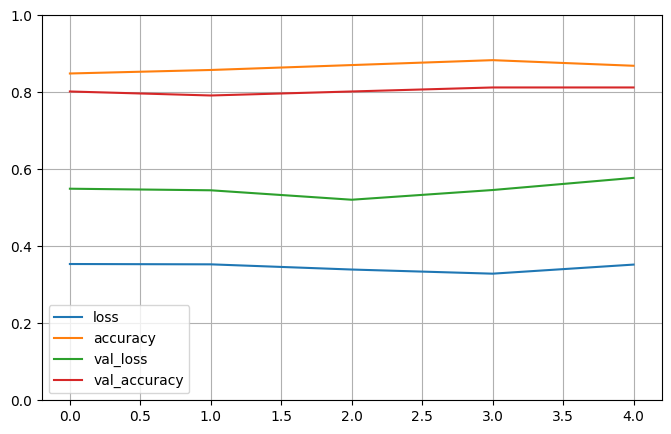

In [76]:
# Evaluate the model on the test set
test_accuracy = model.evaluate(test_generator)

# Display the test accuracy
print(f'Test Accuracy: {test_accuracy[1]}')

pd.DataFrame(vgg_fine_tune.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.savefig ('/content/drive/MyDrive/DL Assignment/VGG16_MODEL_Output.png')
plt.show()

In [77]:
from sklearn.metrics import classification_report
import numpy as np

# Assuming you have the test data and labels
test_data, test_labels = next(test_generator)

# Get model predictions
predictions = model.predict(test_data)
preds = np.argmax(predictions, axis=1)

# Convert one-hot encoded labels to integers
true_labels = np.argmax(test_labels, axis=1)

# Generate classification report
report = classification_report(true_labels, preds, target_names=class_names)

# Print the classification report
print(report)

1/1 [==============================] - 0s 142ms/step
              precision    recall  f1-score   support

   malignant       0.89      0.80      0.84        10
      normal       0.50      1.00      0.67         1
      benign       0.90      0.90      0.90        21

    accuracy                           0.88        32
   macro avg       0.76      0.90      0.80        32
weighted avg       0.89      0.88      0.88        32



#### **Visualizing Predictions- Actual vs Prediction**

1/1 [==============================] - 0s 230ms/step


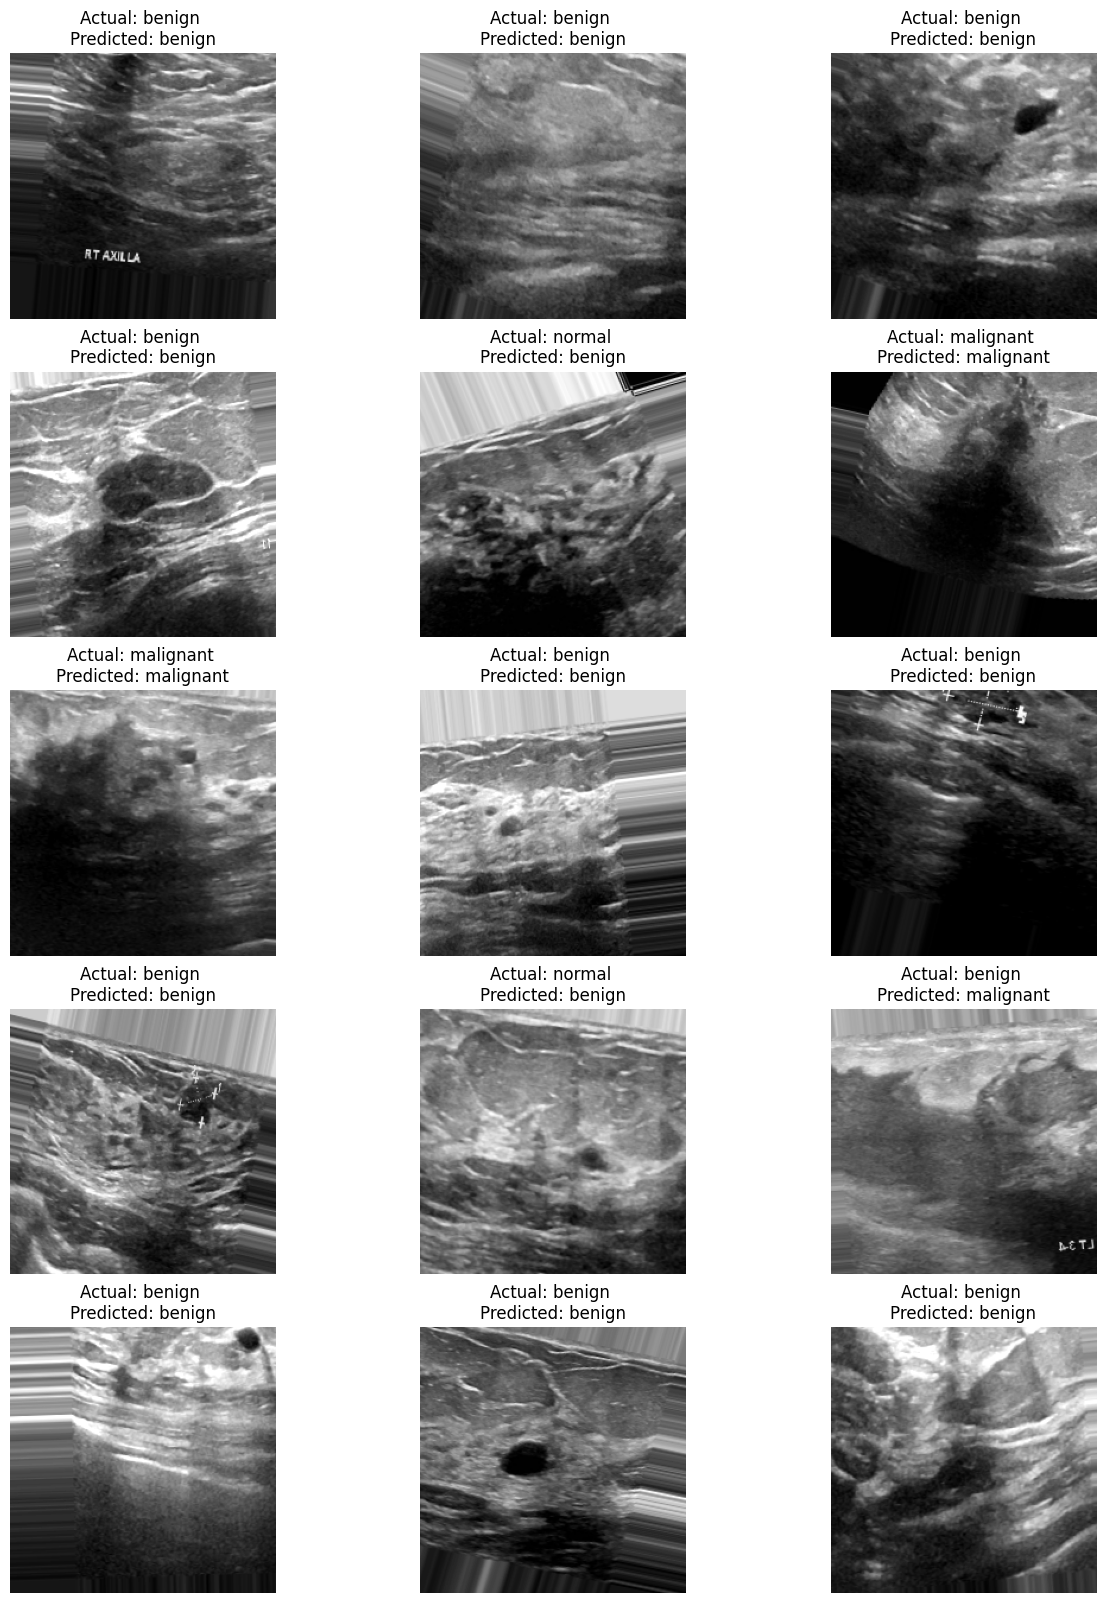

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Set the number of images to display
num_images_to_display = 15

# Create a DataLoader for the test dataset (assuming you have a 'test_generator' for VGG16)
test_data = next(test_generator)

# Get a batch of test data
inputs, labels = test_data

# Convert images to grayscale
grayscale_images = np.mean(inputs, axis=-1)  # Convert RGB to grayscale

# Get model predictions
predictions = model.predict(inputs)
preds = np.argmax(predictions, axis=1)

# Plot the grayscale images with labels and predictions
plt.figure(figsize=(15, 20))  # Increase the height to accommodate 5 rows
for i in range(num_images_to_display):
    ax = plt.subplot(5, 3, i + 1)  # Adjust the layout to 5 rows by 3 columns
    ax.axis('off')
    ax.set_title(f'Actual: {class_names[np.argmax(labels[i])]} \nPredicted: {class_names[preds[i]]}')
    plt.imshow(grayscale_images[i], cmap='gray')  # Display the grayscale image

plt.show()


# **Phase 2 - Classification using overlayed images**

## **Create overlay images**

In [36]:
import warnings

# Suppress DeprecationWarning and ResourceWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ResourceWarning)

# Set the path to the dataset
input_dir = '/content/drive/MyDrive/DL Assignment/Dataset_BUSI_with_GT'

# Set the path to the output folder where overlayed images will be saved
output_dir = '/content/drive/MyDrive/DL Assignment/OverlayedImages'

# Create subdirectories for each label
labels = ['benign', 'malignant', 'normal']
for label in labels:
    os.makedirs(os.path.join(output_dir, label), exist_ok=True)

# Function to overlay images and masks, resize if needed, and save the result
def overlay_and_save(image_path, mask_path, output_path):
    try:
        # Check if both image and mask files exist
        if os.path.exists(image_path) and os.path.exists(mask_path):
            # Open the actual image and mask image
            image = Image.open(image_path)
            mask = Image.open(mask_path)

            # Ensure both images have the same color mode
            if image.mode != mask.mode:
                mask = mask.convert(image.mode)

            # Resize the images if their sizes don't match
            if image.size != mask.size:
                image = image.resize(mask.size)

            # Overlay the image with the mask
            overlayed = Image.blend(image, mask, alpha=0.5)

            # Save the overlayed image to the appropriate label folder
            label = os.path.basename(os.path.dirname(image_path))
            output_path = os.path.join(output_dir, label, os.path.basename(image_path))
            overlayed.save(output_path)
        else:
            #print(f"File not found for: {image_path} or {mask_path}. Skipping...")
            pass
    except Exception as e:
        print(f"An error occurred for: {image_path} or {mask_path}. Error: {str(e)}")

# Iterate through the subdirectories (benign, malignant, normal)
for label in labels:
    label_dir = os.path.join(input_dir, label)
    if os.path.isdir(label_dir):
        for image_filename in os.listdir(label_dir):
            if image_filename.endswith('.png'):
                image_path = os.path.join(label_dir, image_filename)
                # Construct the mask file path based on the naming convention
                mask_filename = image_filename.replace('.png', '_mask.png')
                mask_path = os.path.join(label_dir, mask_filename)
                overlay_and_save(image_path, mask_path, output_dir)

print("Overlayed images have been saved.")

Overlayed images have been saved.


## **Before and After Overlay Image labelling and Counting**

Before/after overlay counts - There are few mask files with a  non standard naming convention in the folders like _mask_1 and _mask_2, we will ignore since it is only a few samples which will not impact accuracy too much.

In [78]:
import os

# Function to count the number of files in a directory
def count_files_in_directory(directory):
    return sum(len(files) for _, _, files in os.walk(directory))

# Set the paths to the input and output directories
input_dir = '/content/drive/MyDrive/DL Assignment/Dataset_BUSI_with_GT'
output_dir = '/content/drive/MyDrive/DL Assignment/OverlayedImages'

# Count the files in the input and output directories
input_counts = {}
output_counts = {}

# Count files in input directory
for label in os.listdir(input_dir):
    label_dir = os.path.join(input_dir, label)
    if os.path.isdir(label_dir):
        input_counts[label] = count_files_in_directory(label_dir)

# Count files in output directory
for label in os.listdir(output_dir):
    label_dir = os.path.join(output_dir, label)
    if os.path.isdir(label_dir):
        output_counts[label] = count_files_in_directory(label_dir)

# Print file counts
print("File Counts Before Overlay-includes masks:")
for label, count in input_counts.items():
    print(f"{label}: {count} files")

print("\nFile Counts After Overlay:")
for label, count in output_counts.items():
    print(f"{label}: {count} files")


File Counts Before Overlay-includes masks:
malignant: 421 files
benign: 916 files
normal: 266 files

File Counts After Overlay:
benign: 437 files
malignant: 210 files
normal: 133 files
train: 581 files
validation: 103 files
test: 121 files


## **Overview of the Dataset for each Class**

Display overlayed images- Randomly 4 images from each class

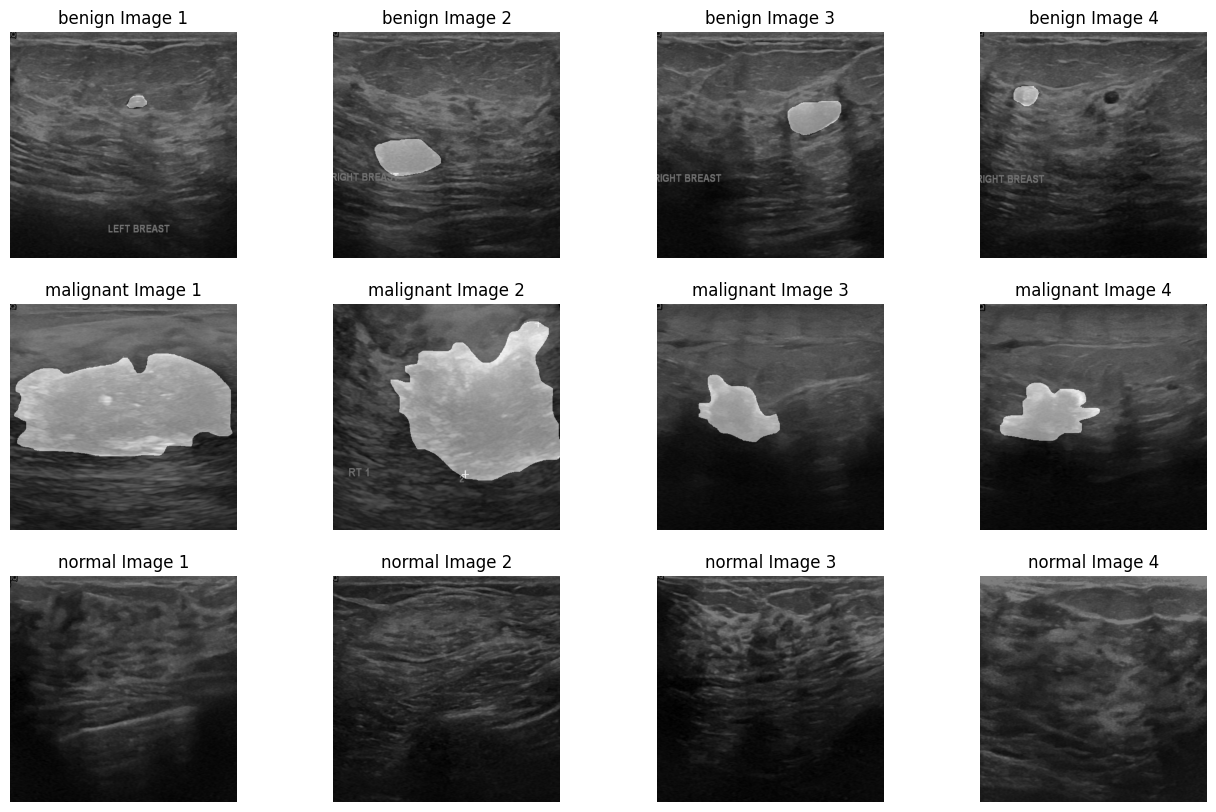

In [79]:
# Set the path to the overlayed images directory
overlayed_dir = '/content/drive/MyDrive/DL Assignment/OverlayedImages'

# Create subdirectories for each label
labels = ['benign', 'malignant', 'normal']
label_dirs = [os.path.join(overlayed_dir, label) for label in labels]

# Create a figure to display the images
fig, axs = plt.subplots(3, 4, figsize=(16, 10))

# Desired width and height for each image
desired_width = 800  # Adjust as needed
desired_height = 800  # Adjust as needed

# Loop through each label and display the first 4 images
for i, label_dir in enumerate(label_dirs):
    # Get a list of image files and sort them
    images = [image for image in os.listdir(label_dir) if image.endswith('.png')]
    images.sort(key=lambda x: int(x.split('(')[1].split(')')[0]))  # Sort the images by number in parentheses

    for j, image_filename in enumerate(images[:4]):  # Display the first 4 images
        image_path = os.path.join(label_dir, image_filename)
        image = Image.open(image_path)

        # Resize the image to the desired width and height
        image = image.resize((desired_width, desired_height), Image.ANTIALIAS)

        # Display the image in the subplot
        axs[i, j].imshow(image)
        axs[i, j].set_title(f'{labels[i]} Image {j + 1}')
        axs[i, j].axis('off')

plt.show()

Display the image , mask and overlay side by side for a better visualization.

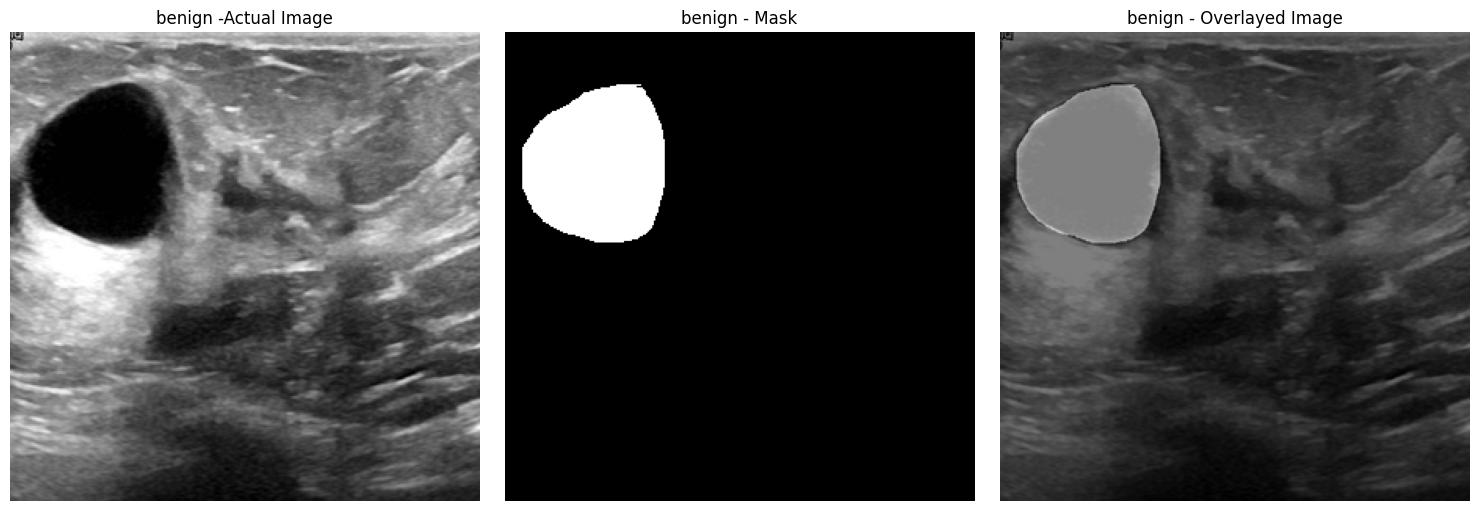

In [57]:
# Define the directory paths
overlayed_dir = '/content/drive/MyDrive/DL Assignment/OverlayedImages/benign'

# Create a figure to display the images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Desired width and height for display
desired_width = 300
desired_height = 300

# Select an image (change the index as needed)
image_filename = 'benign (10).png'

# Construct the file paths
actual_image_path = os.path.join(input_dir, 'benign', image_filename)
mask_image_path = os.path.join(input_dir, 'benign', image_filename.replace(".png", "_mask.png"))
overlayed_image_path = os.path.join(overlayed_dir, image_filename)

# Load the images
actual_image = Image.open(actual_image_path)
mask_image = Image.open(mask_image_path)
overlayed_image = Image.open(overlayed_image_path)

# Resize the images
actual_image = actual_image.resize((desired_width, desired_height), Image.ANTIALIAS)
mask_image = mask_image.resize((desired_width, desired_height), Image.ANTIALIAS)
overlayed_image = overlayed_image.resize((desired_width, desired_height), Image.ANTIALIAS)

# Display the images
axs[0].imshow(actual_image)
axs[0].set_title('benign -Actual Image')
axs[0].axis('off')

axs[1].imshow(mask_image, cmap='gray')
axs[1].set_title('benign - Mask')
axs[1].axis('off')

axs[2].imshow(overlayed_image)
axs[2].set_title('benign - Overlayed Image')
axs[2].axis('off')

plt.tight_layout()
plt.show()


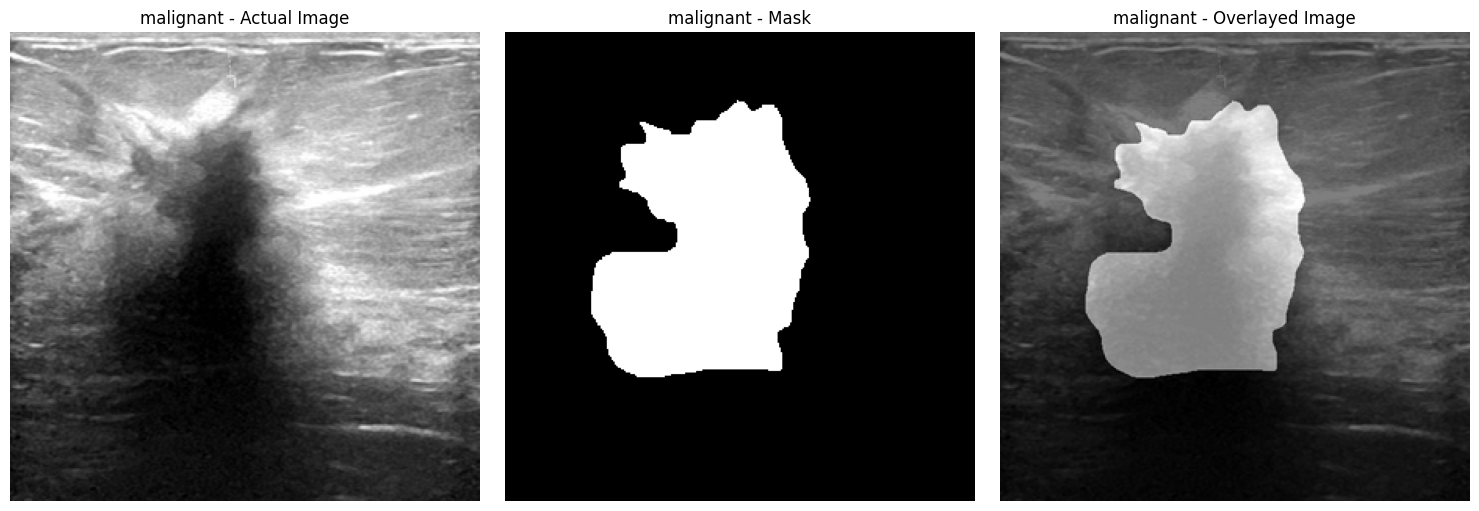

In [10]:
# Define the directory paths
overlayed_dir = '/content/drive/MyDrive/DL Assignment/OverlayedImages/malignant'

# Create a figure to display the images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Desired width and height for display
desired_width = 300
desired_height = 300

# Select an image (change the index as needed)
image_filename = 'malignant (103).png'

# Construct the file paths
actual_image_path = os.path.join(input_dir, 'malignant', image_filename)
mask_image_path = os.path.join(input_dir, 'malignant', image_filename.replace(".png", "_mask.png"))
overlayed_image_path = os.path.join(overlayed_dir, image_filename)

# Load the images
actual_image = Image.open(actual_image_path)
mask_image = Image.open(mask_image_path)
overlayed_image = Image.open(overlayed_image_path)

# Resize the images
actual_image = actual_image.resize((desired_width, desired_height), Image.ANTIALIAS)
mask_image = mask_image.resize((desired_width, desired_height), Image.ANTIALIAS)
overlayed_image = overlayed_image.resize((desired_width, desired_height), Image.ANTIALIAS)

# Display the images
axs[0].imshow(actual_image)
axs[0].set_title('malignant - Actual Image')
axs[0].axis('off')

axs[1].imshow(mask_image, cmap='gray')
axs[1].set_title('malignant - Mask')
axs[1].axis('off')

axs[2].imshow(overlayed_image)
axs[2].set_title('malignant - Overlayed Image')
axs[2].axis('off')

plt.tight_layout()
plt.show()

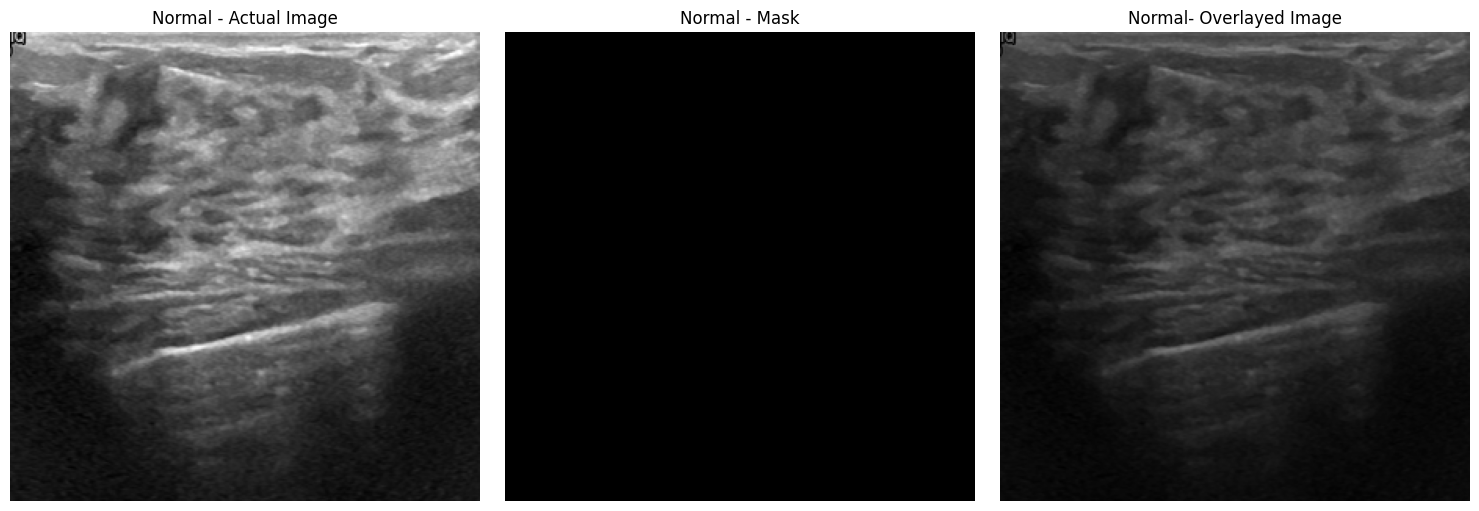

In [11]:
# Define the directory paths
overlayed_dir = '/content/drive/MyDrive/DL Assignment/OverlayedImages/normal'

# Create a figure to display the images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Desired width and height for display
desired_width = 300
desired_height = 300

# Select an image (change the index as needed)
image_filename = 'normal (1).png'

# Construct the file paths
actual_image_path = os.path.join(input_dir, 'normal', image_filename)
mask_image_path = os.path.join(input_dir, 'normal', image_filename.replace(".png", "_mask.png"))
overlayed_image_path = os.path.join(overlayed_dir, image_filename)

# Load the images
actual_image = Image.open(actual_image_path)
mask_image = Image.open(mask_image_path)
overlayed_image = Image.open(overlayed_image_path)

# Resize the images
actual_image = actual_image.resize((desired_width, desired_height), Image.ANTIALIAS)
mask_image = mask_image.resize((desired_width, desired_height), Image.ANTIALIAS)
overlayed_image = overlayed_image.resize((desired_width, desired_height), Image.ANTIALIAS)

# Display the images
axs[0].imshow(actual_image)
axs[0].set_title('Normal - Actual Image')
axs[0].axis('off')

axs[1].imshow(mask_image, cmap='gray')
axs[1].set_title('Normal - Mask')
axs[1].axis('off')

axs[2].imshow(overlayed_image)
axs[2].set_title('Normal- Overlayed Image')
axs[2].axis('off')

plt.tight_layout()
plt.show()

## **Create train/test validation folders and data split**

In [55]:
# Set the path to your input folder
data_dir = '/content/drive/MyDrive/DL Assignment/Dataset_BUSI_with_GT'

# Create a list to store file paths and labels
file_paths = []
labels = []

# Loop through the subdirectories (benign, malignant, normal)
for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        for image_file in os.listdir(label_dir):
            if image_file.endswith('.png') and not (image_file.endswith('_mask.png') or
                                                     image_file.endswith('_mask_1.png') or
                                                     image_file.endswith('_mask_2.png')):
                image_path = os.path.join(label_dir, image_file)
                labels.append(label)
                file_paths.append(image_path)

# Create a DataFrame to store the file paths and labels
data = pd.DataFrame({'Image_Path': file_paths, 'Label': labels})

# Split the dataset into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.15, random_state=42, stratify=data['Label'])
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42, stratify=train_data['Label'])

# Define the paths for the train, validation, and test directories
train_dir = '/content/drive/MyDrive/DL Assignment/OverlayedImages/train'
val_dir = '/content/drive/MyDrive/DL Assignment/OverlayedImages/validation'
test_dir = '/content/drive/MyDrive/DL Assignment/OverlayedImages/test'

# Create the train, validation, and test directories and subdirectories
for label in labels:
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

# Copy the images to the corresponding directories
for _, row in train_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(train_dir, label))

for _, row in val_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(val_dir, label))

for _, row in test_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(test_dir, label))

## **Get the label counts after split - excludes mask files**

In [56]:
import os
train_dir = '/content/drive/MyDrive/DL Assignment/OverlayedImages/train'

# List the subdirectories (benign, malignant, normal)
subdirectories = ['benign', 'malignant', 'normal']

# Dictionary to store file counts
file_counts = {}

# Loop through the subdirectories and count files in each
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(train_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

# Print the file counts
for category, count in file_counts.items():
   # print("Train folder counts including masks:")
    print(f"Train {category}: {count}")

validation_dir = '/content/drive/MyDrive/DL Assignment/OverlayedImages/validation'

# List the subdirectories (benign, malignant, normal)
subdirectories = ['benign', 'malignant', 'normal']

# Dictionary to store file counts
file_counts = {}

# Loop through the subdirectories and count files in each
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(validation_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

# Print the file counts
for category, count in file_counts.items():
    #print("Validation folder counts including masks:")
    print(f"Validation {category}: {count}")


test_dir = '/content/drive/MyDrive/DL Assignment/OverlayedImages/test'

# List the subdirectories (benign, malignant, normal)
subdirectories = ['benign', 'malignant', 'normal']

# Dictionary to store file counts
file_counts = {}

# Loop through the subdirectories and count files in each
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(test_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

# Print the file counts
for category, count in file_counts.items():
    #print("test folder counts including masks:")
    print(f"test {category}: {count}")

Train benign: 334
Train malignant: 151
Train normal: 96
Validation benign: 59
Validation malignant: 27
Validation normal: 17
test benign: 69
test malignant: 32
test normal: 20


### **Model 1: Resnet50**

#### **Apply Data transformation and Augmentation**

Transformation and Augmentation - Using the same function, again giving more weight to the minority classes

In [ ]:
# Define the minority classes in your dataset
class_names = ['malignant', 'normal','benign']
minority_classes = ['malignant', 'normal']

# Define custom data transformations for minority classes
minority_class_transforms = transforms.Compose([
    RandomHorizontalFlip(p=0.9),  # Apply with 90% probability
    RandomRotation(15, expand=False, center=None),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

# Define data transformations for train, validation, and test sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        # Apply custom augmentations to minority classes
        transforms.RandomApply([minority_class_transforms], p=0.5) if any(cls in minority_classes for cls in class_names) else transforms.RandomApply([], p=0.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
data_dir='/content/drive/MyDrive/DL Assignment/OverlayedImages'

# Create datasets for train, validation, and test
image_datasets = {
    x: ImageFolder(
        root=os.path.join(data_dir, x),
        transform=data_transforms[x]
    )
    for x in ['train', 'validation', 'test']
}

# Specify batch size for dataloaders
batch_size = 8  # You can adjust this based on your hardware and preferences

# Create dataloaders for train, validation, and test
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
               for x in ['train', 'validation', 'test']}

# Calculate dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}

# Get class labels
class_names = image_datasets['train'].classes

# Print dataset sizes and class labels
print("Dataset Sizes:", dataset_sizes)
print("Class Labels:", class_names)

Dataset Sizes: {'train': 581, 'validation': 103, 'test': 121}
Class Labels: ['benign', 'malignant', 'normal']


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [46]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### **Model Fitting**

In [ ]:
#Transfer Learning by fineTuning the pretrained Resnet101 Model
#Load Resnet101 pretained Model
#Resnet101 = models.resnet101(pretrained=True)
#If pretained is not working, you can also use weights instead.
Resnet101 = models.resnet101(weights=True)

print(Resnet101)
#Set the resnet param.requires_grad = True to calculate the gradient,
#so that model fine-tunes the weights of the pretrained network
#by continuing the backpropagation.
for param in Resnet101.parameters():
    param.requires_grad = True

#Get the number of Input features of Resnet last fully connected layer
#because we are going to replace it with new fully connected layer.
in_features = Resnet101.fc.in_features

#Reset the final fully connected layer of the of the pre-trained Resnet.
Resnet101.fc = nn.Linear(in_features, len(class_names))

Resnet_fineTuning = Resnet101.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:02<00:00, 84.1MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#Define optimzation algorithm
optimizer = optim.Adam(Resnet_fineTuning.parameters(), lr=0.00005)

# Decay LR by a factor of 0.1 every 7 epochs
Decay_Learning_Rate = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

#Define loss functions
Loss_Function = nn.CrossEntropyLoss()

#### **Fine Tune with learning rate**

In [ ]:
model_fineTuning = train_model_with_early_stopping(
    Resnet_fineTuning, Loss_Function, optimizer, Decay_Learning_Rate,
    dataloaders, dataset_sizes, class_names, device,num_epochs=20, patience=2)
torch.save(model_fineTuning, "/content/drive/MyDrive/DL Assignment/Resnet_fineTuning2.pth")

Epoch 0/19
----------
train Loss: 0.4274 Acc: 0.8472
validation Loss: 0.1291 Acc: 0.9700

Epoch 1/19
----------
train Loss: 0.1675 Acc: 0.9538
validation Loss: 0.0982 Acc: 0.9700

Epoch 2/19
----------
train Loss: 0.1365 Acc: 0.9609
validation Loss: 0.0779 Acc: 0.9600

Epoch 3/19
----------
train Loss: 0.1012 Acc: 0.9680
validation Loss: 0.0872 Acc: 0.9700

Epoch 4/19
----------
train Loss: 0.1115 Acc: 0.9680
validation Loss: 0.0489 Acc: 1.0000

Epoch 5/19
----------
train Loss: 0.0680 Acc: 0.9787
validation Loss: 0.0449 Acc: 0.9800

Epoch 6/19
----------
train Loss: 0.0515 Acc: 0.9840
validation Loss: 0.0643 Acc: 0.9800

Epoch 7/19
----------
train Loss: 0.0457 Acc: 0.9947
validation Loss: 0.0679 Acc: 0.9800
Early stopping after 7 epochs
Training complete in 1m 35s
Best val Loss: 0.0449
              precision    recall  f1-score   support

      benign       0.98      0.98      0.98        56
   malignant       1.00      0.96      0.98        27
      normal       0.94      1.00     

#### **Model Evaluation**

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


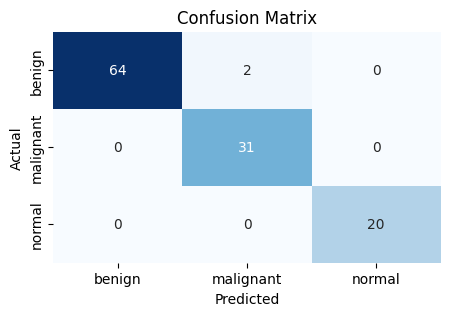

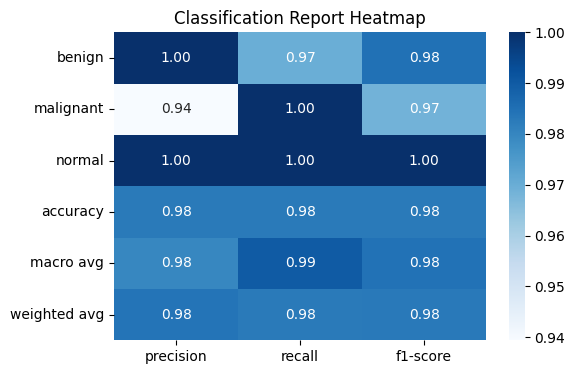

Simplified Classification Report:
             benign  malignant  normal  accuracy  macro avg  weighted avg
precision  1.000000   0.939394     1.0  0.982906   0.979798      0.983942
recall     0.969697   1.000000     1.0  0.982906   0.989899      0.982906
f1-score   0.984615   0.968750     1.0  0.982906   0.984455      0.983042


In [ ]:
# Define label names
label_names = [str(class_names[i]) for i in range(len(class_names))]

# Calculate classification report and confusion matrix on unseen test data
y_true = []
y_pred = []

model_fineTuning.eval()  # Set model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_fineTuning(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Generate classification report
classification_rep = classification_report(y_true, y_pred, target_names=label_names, output_dict=True)

# Generate confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix with label names
plt.figure(figsize=(5, 3))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Convert the classification report to a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(pd.DataFrame(classification_rep).iloc[:-1, :].T, annot=True, cmap='Blues', fmt='.2f')  # Simplify classification report
plt.title('Classification Report Heatmap')
plt.show()

# Print the simplified classification report
print("Simplified Classification Report:")
print(pd.DataFrame(classification_rep).iloc[:-1, :])  # Display without support and avg/total rows

#### **Visualizing Predictions- Actual vs Prediction**

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


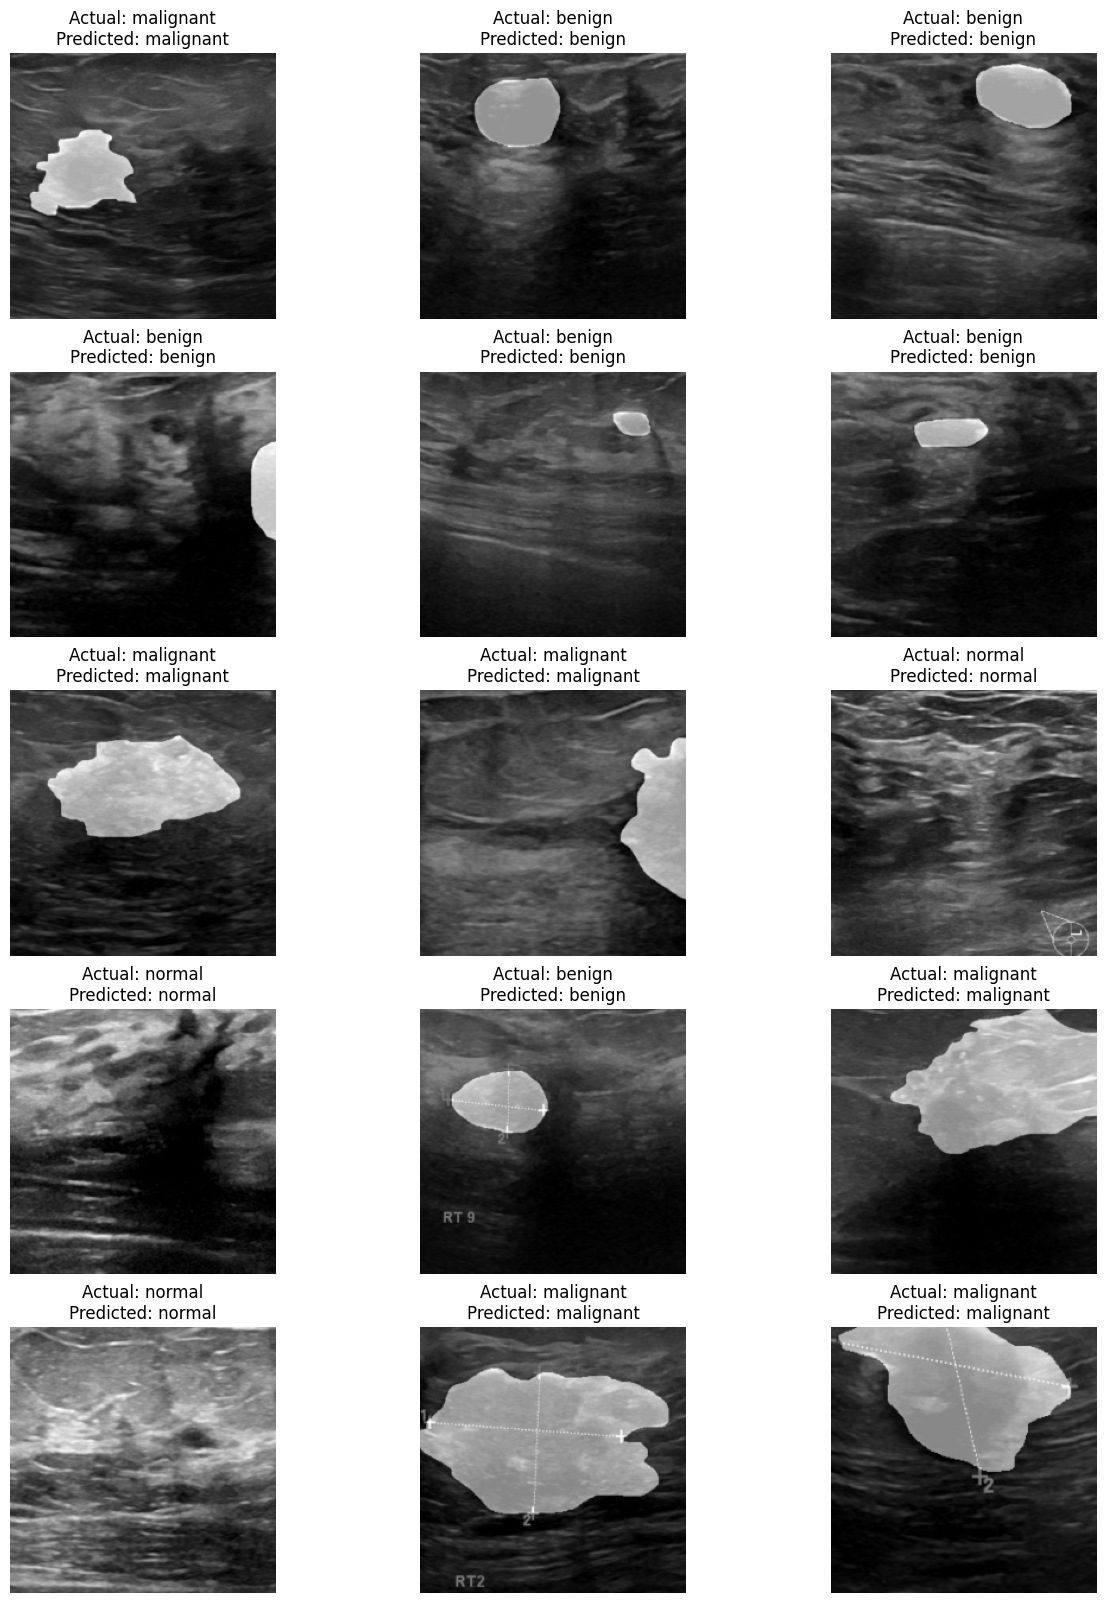

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set the number of images to display
num_images_to_display = 15

# Create a DataLoader for the test dataset
test_dataloader = DataLoader(image_datasets['test'], batch_size=num_images_to_display, shuffle=True, num_workers=4)

# Get a batch of test data
inputs, labels = next(iter(test_dataloader))

# Move inputs to the device
inputs = inputs.to(device)

# Convert images to grayscale
grayscale_images = inputs.cpu().numpy().mean(axis=1)  # Convert RGB to grayscale

# Get model predictions
with torch.no_grad():
    model_fineTuning.eval()
    outputs = model_fineTuning(inputs)
    _, preds = torch.max(outputs, 1)

# Plot the grayscale images with labels and predictions
plt.figure(figsize=(15, 20))  # Increase the height to accommodate 5 rows
for i in range(num_images_to_display):
    ax = plt.subplot(5, 3, i + 1)  # Adjust the layout to 5 rows by 3 columns
    ax.axis('off')
    ax.set_title(f'Actual: {class_names[labels[i]]}\nPredicted: {class_names[preds[i]]}')
    plt.imshow(grayscale_images[i], cmap='gray')  # Display the grayscale image

plt.show()

### **Model 2-VGG 16 CNN**

#### **Data Augmentaion with ImageDataGenerator**

In [89]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the minority classes in your dataset
class_names = ['malignant', 'normal', 'benign']
minority_classes = ['malignant', 'normal']

# Create an instance of ImageDataGenerator for data augmentation
data_generator = ImageDataGenerator(
    rescale=1./255
)

# Define custom data generators for train, validation, and test sets
train_generator = data_generator.flow_from_directory(
    '/content/drive/MyDrive/DL Assignment/OverlayedImages/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=class_names,
)

validation_generator = data_generator.flow_from_directory(
    '/content/drive/MyDrive/DL Assignment/OverlayedImages/validation',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=class_names,
)

test2_generator = data_generator.flow_from_directory(
    '/content/drive/MyDrive/DL Assignment/OverlayedImages/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=class_names,
)

Found 581 images belonging to 3 classes.
Found 103 images belonging to 3 classes.
Found 121 images belonging to 3 classes.


#### **Model Fitting**

In [81]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten(name='flattened'))
model.add(Dropout(0.5, name='dropout1'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3, name='dropout2'))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flattened (Flatten)         (None, 25088)             0         
                                                                 
 dropout1 (Dropout)          (None, 25088)             0         
                                                                 
 dense_10 (Dense)            (None, 256)               6422784   
                                                                 
 dropout2 (Dropout)          (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 3)                 771       
                                                                 
Total params: 21138243 (80.64 MB)
Trainable params: 64

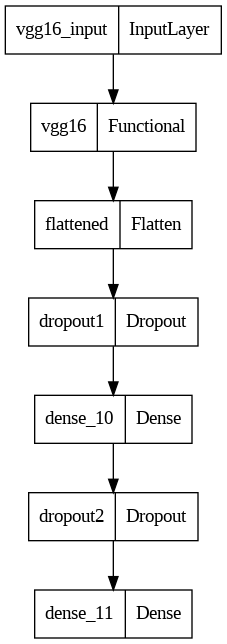

In [93]:
from keras.utils import  plot_model
from keras import optimizers
plot_model(model)

#### **Model Training with early stop and DataGenerators**

In [82]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Define the ModelCheckpoint callback to save the best model weights
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/DL Assignment/best_vgg16_model_Overlayed.h5',
                                   save_best_only=True,
                                   monitor='val_loss',
                                   mode='min',  # 'min' for loss, 'max' for accuracy, 'auto' to infer automatically
                                   verbose=1)

# Train the model with early stopping and data generators
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, model_checkpoint],  # Include both callbacks
)

Epoch 1/20
18/18 [==============================] - ETA: 0s - loss: 2.2002 - accuracy: 0.5082
Epoch 1: val_loss improved from inf to 1.01818, saving model to /content/drive/MyDrive/DL Assignment/best_vgg16_model_Overlayed.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - 12s 587ms/step - loss: 2.2002 - accuracy: 0.5082 - val_loss: 1.0182 - val_accuracy: 0.5833
Epoch 2/20
18/18 [==============================] - ETA: 0s - loss: 0.7775 - accuracy: 0.6594
Epoch 2: val_loss improved from 1.01818 to 0.73798, saving model to /content/drive/MyDrive/DL Assignment/best_vgg16_model_Overlayed.h5
18/18 [==============================] - 10s 583ms/step - loss: 0.7775 - accuracy: 0.6594 - val_loss: 0.7380 - val_accuracy: 0.6875
Epoch 3/20
18/18 [==============================] - ETA: 0s - loss: 0.6464 - accuracy: 0.7250
Epoch 3: val_loss improved from 0.73798 to 0.66180, saving model to /content/drive/MyDrive/DL Assignment/best_vgg16_model_Overlayed.h5
18/18 [==============================] - 8s 453ms/step - loss: 0.6464 - accuracy: 0.7250 - val_loss: 0.6618 - val_accuracy: 0.7188
Epoch 4/20
18/18 [==============================] - ETA: 0s - loss: 0.5736 - accuracy: 0.7468
Epoch 4: val_loss improved from 0.66180 to 0.60485, s

#### **Fine Tuning with Learning Rate**

In [86]:
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Unfreeze the last few layers of the VGG16 model
for layer in model.layers[0].layers[:-4]:
    layer.trainable = True

# Compile the model again after unfreezing layers
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-5),  # Use a lower learning rate for fine-tuning
    metrics=['accuracy']
)

# Fine-tune the model with a specific learning rate
learning_rate_fine_tune = 1e-6  # Set your desired learning rate for fine-tuning

# Compile the model with the new learning rate for fine-tuning
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=learning_rate_fine_tune),
    metrics=['accuracy']
)

# Fine-tune the model
vgg_fine_tune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,  # Set the number of fine-tuning epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping],  # Include the EarlyStopping callback
)

# Save the best model
model.save('/content/drive/MyDrive/DL Assignment/best_vgg16_model_overlayed.h5')


Epoch 1/20
18/18 [==============================] - 12s 514ms/step - loss: 0.3965 - accuracy: 0.8579 - val_loss: 0.5630 - val_accuracy: 0.7812
Epoch 2/20
18/18 [==============================] - 10s 524ms/step - loss: 0.3440 - accuracy: 0.8743 - val_loss: 0.5381 - val_accuracy: 0.7917
Epoch 3/20
18/18 [==============================] - 8s 438ms/step - loss: 0.3615 - accuracy: 0.8470 - val_loss: 0.5465 - val_accuracy: 0.8021
Epoch 4/20
18/18 [==============================] - 10s 531ms/step - loss: 0.3407 - accuracy: 0.8628 - val_loss: 0.6054 - val_accuracy: 0.7917


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### **Model Evaluation**

4/4 [==============================] - 2s 407ms/step - loss: 0.5455 - accuracy: 0.8017
Test Accuracy: 0.8016529083251953


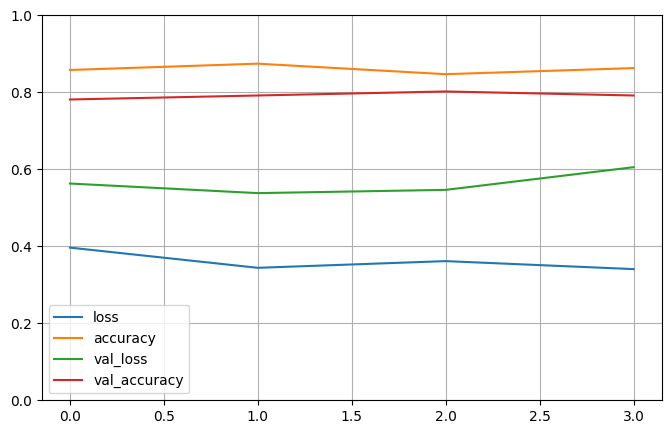

In [90]:
# Evaluate the model on the test set
test_accuracy = model.evaluate(test2_generator)

# Display the test accuracy
print(f'Test Accuracy: {test_accuracy[1]}')

pd.DataFrame(vgg_fine_tune.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.savefig ('/content/drive/MyDrive/DL Assignment/VGG16 MODEL Output.png')
plt.show()

In [91]:
from sklearn.metrics import classification_report
import numpy as np

# Assuming you have the test data and labels
test_data, test_labels = next(test2_generator)

# Get model predictions
predictions = model.predict(test_data)
preds = np.argmax(predictions, axis=1)

# Convert one-hot encoded labels to integers
true_labels = np.argmax(test_labels, axis=1)

# Generate classification report
report = classification_report(true_labels, preds, target_names=class_names)

# Print the classification report
print(report)

1/1 [==============================] - 0s 38ms/step
              precision    recall  f1-score   support

   malignant       0.67      0.44      0.53         9
      normal       0.75      0.38      0.50         8
      benign       0.64      0.93      0.76        15

    accuracy                           0.66        32
   macro avg       0.68      0.58      0.60        32
weighted avg       0.67      0.66      0.63        32



#### **Visualizing Predictions- Actual vs Prediction**

1/1 [==============================] - 0s 37ms/step


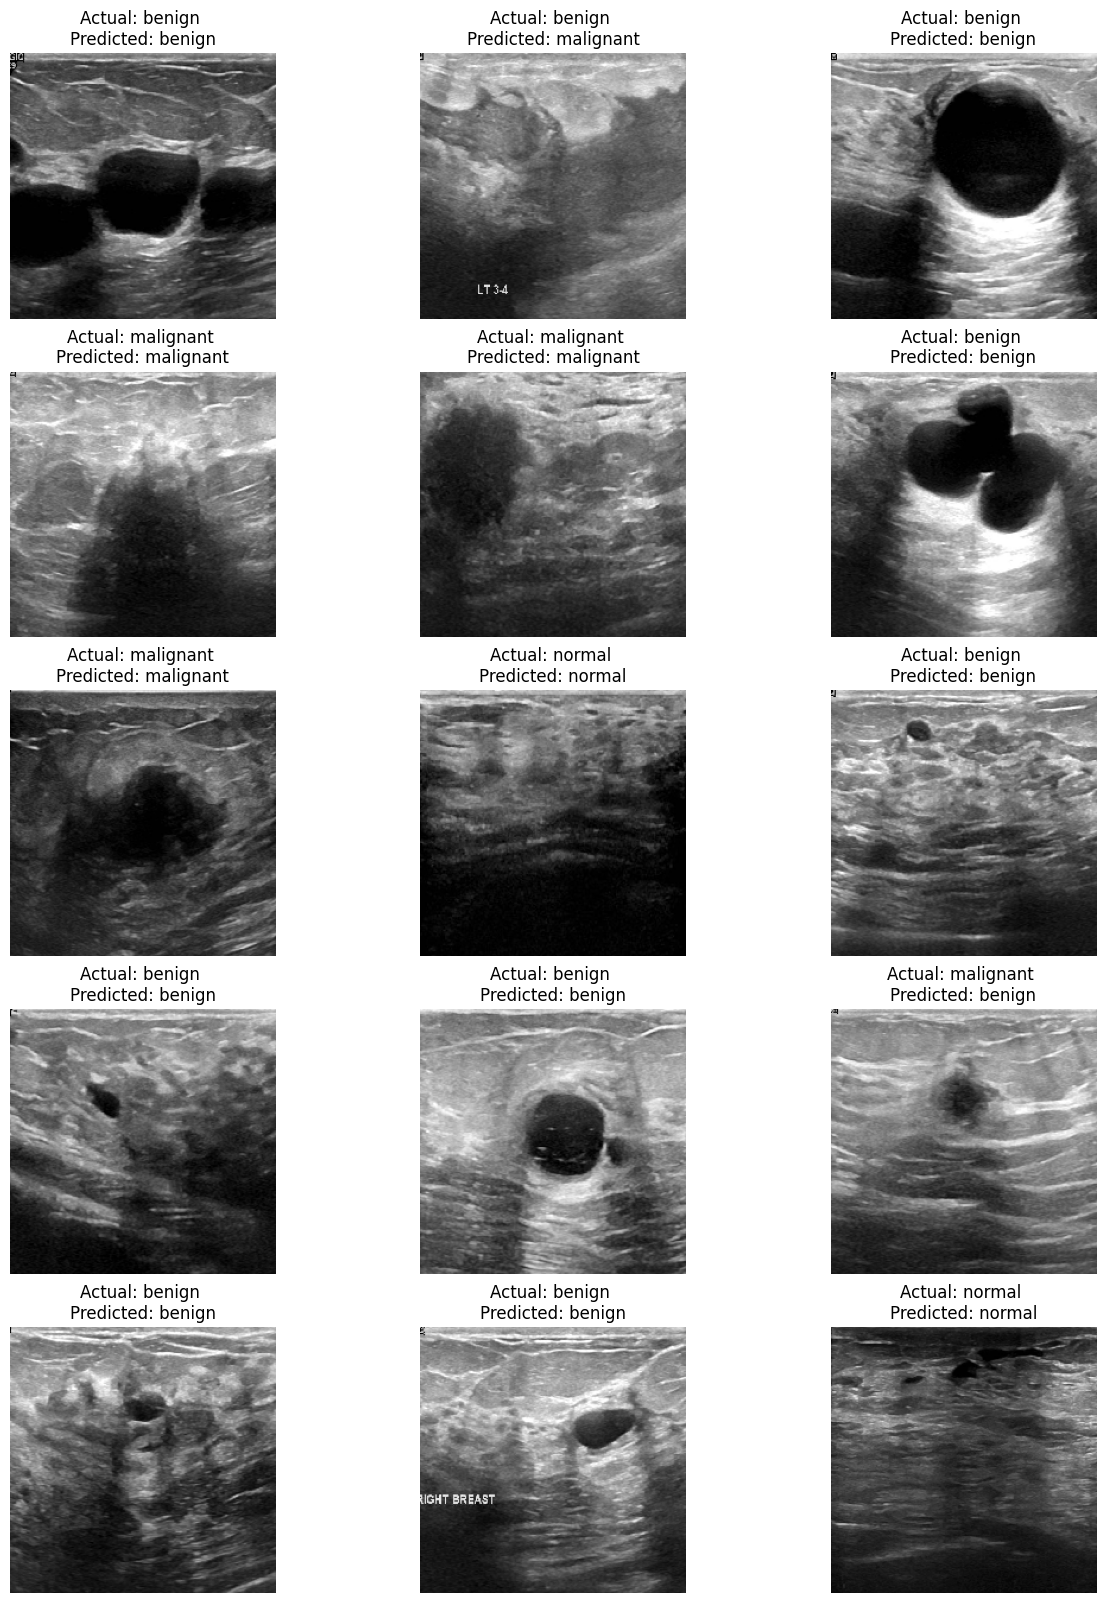

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Set the number of images to display
num_images_to_display = 15

# Create a DataLoader for the test dataset (assuming you have a 'test_generator' for VGG16)
test_data = next(iter(test2_generator))

# Get a batch of test data
inputs, labels = test_data

# Convert images to grayscale
grayscale_images = np.mean(inputs, axis=-1)  # Convert RGB to grayscale

# Get model predictions
predictions = model.predict(inputs)
preds = np.argmax(predictions, axis=1)

# Plot the grayscale images with labels and predictions
plt.figure(figsize=(15, 20))  # Increase the height to accommodate 5 rows
for i in range(num_images_to_display):
    ax = plt.subplot(5, 3, i + 1)  # Adjust the layout to 5 rows by 3 columns
    ax.axis('off')
    ax.set_title(f'Actual: {class_names[np.argmax(labels[i])]} \nPredicted: {class_names[preds[i]]}')

    # Display the original RGB image
    plt.imshow(inputs[i])

    # Overlay the grayscale image
    plt.imshow(grayscale_images[i], cmap='gray', alpha=0.5)

plt.show()